In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import os
plt.rcParams['figure.figsize'] = [20, 10]

In [3]:
import torch
import numpy as np

In [4]:
import abbyy_course_cvdl_t2

In [5]:
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.convert import ObjectsToPoints
from abbyy_course_cvdl_t2.loss import CenterNetLoss
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [6]:
import abbyy_course_cvdl_t2
TINY_COCO_BASE = Path(abbyy_course_cvdl_t2.__file__).parent.parent / 'data'
TINY_COCO_BASE.exists()

True

In [7]:
from torchvision.datasets import CocoDetection

Если CocoDetection падает, вероятно, вам нужно установить pycocotools: `pip install pycocotools`

Раньше pycocotools требовал предварительную установки cython:
`pip install cython`
Раньше установка на windows работала криво: https://stackoverflow.com/questions/52920222/could-not-install-pycocotools-in-windows-fatal-error-c1083-cannot-open-include

На новых версиях python на windows теперь работает ок.

In [8]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [9]:
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection

In [10]:
ds_text = CocoTextDetection(
    Path("data\\train2014"),
    Path("data\\cocotext.v2.json"),
    transforms=CocoDetectionPrepareTransform(size=(256,256), ids_map = {1: 0, 0:0}
),
    area_fraction_threshold=1/32/32
)

In [11]:
x, y = ds_text[6]

In [12]:
y[:10]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_21376\2386193706.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  yc - hy//2 - thick : yc - hy//2 + thick,
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_21376\2386193706.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  xc - wx//2 : xc + wx//2,
C:\Users\Aleksei\AppData\Local\Temp\ip

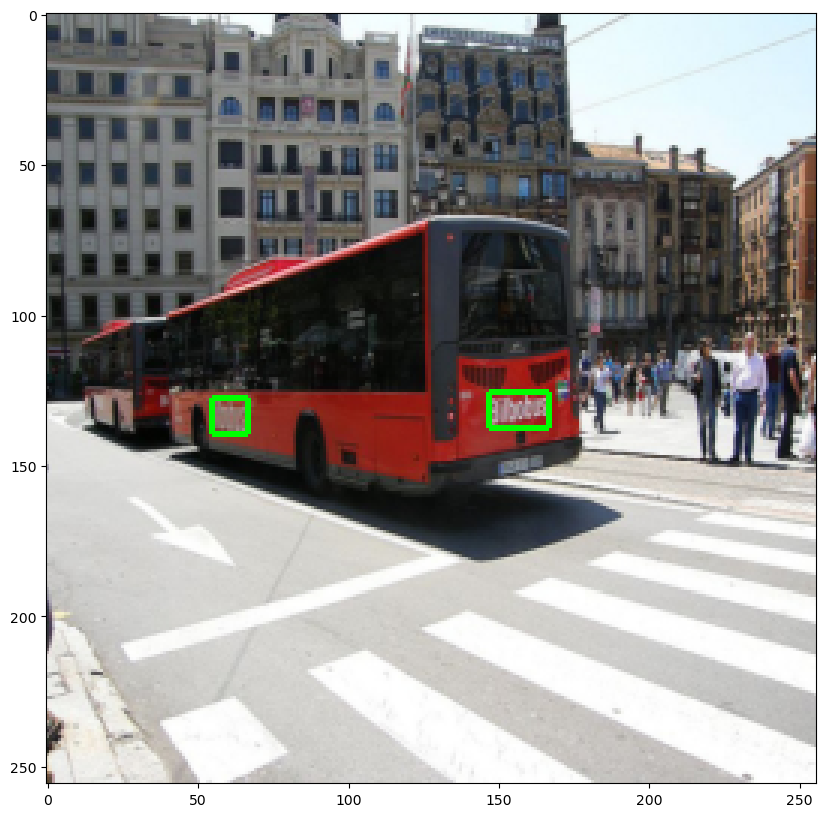

In [13]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
#plt.imshow(x.permute(1, 2, 0))

In [14]:
net = CenterNet(head_kwargs={'c_classes': 1}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=1))

C:\Users\Aleksei\anaconda3\envs\data_science_3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Aleksei\anaconda3\envs\data_science_3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
net = train(ds_text, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device('cuda'), lr=1e-3)

tensor(414.5039, device='cuda:0', grad_fn=<SumBackward0>)
epoch 0|0; total loss:13.81679630279541
last losses: [413.7601318359375, 0.2509731948375702, 0.4927803874015808]
tensor(172.0579, device='cuda:0', grad_fn=<SumBackward0>)
tensor(70.5472, device='cuda:0', grad_fn=<SumBackward0>)
tensor(30.1997, device='cuda:0', grad_fn=<SumBackward0>)
tensor(12.3640, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6.4218, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3.7308, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.7930, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.5256, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.4407, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.8732, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.6169, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.4994, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.7408, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.4597, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.6602, device='cuda:0', grad_fn=

KeyboardInterrupt: 

In [16]:
with torch.no_grad():
    yp_heat = net(x[None].to('cuda')).cpu()
    yp = net(x[None].to('cuda'), return_objects=True).cpu()

D:\Homework\course_cvdl\task2\abbyy_course_cvdl_t2\convert.py:201: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  classes = indices // (h * w)
D:\Homework\course_cvdl\task2\abbyy_course_cvdl_t2\convert.py:202: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ind_y = (indices // w) % h


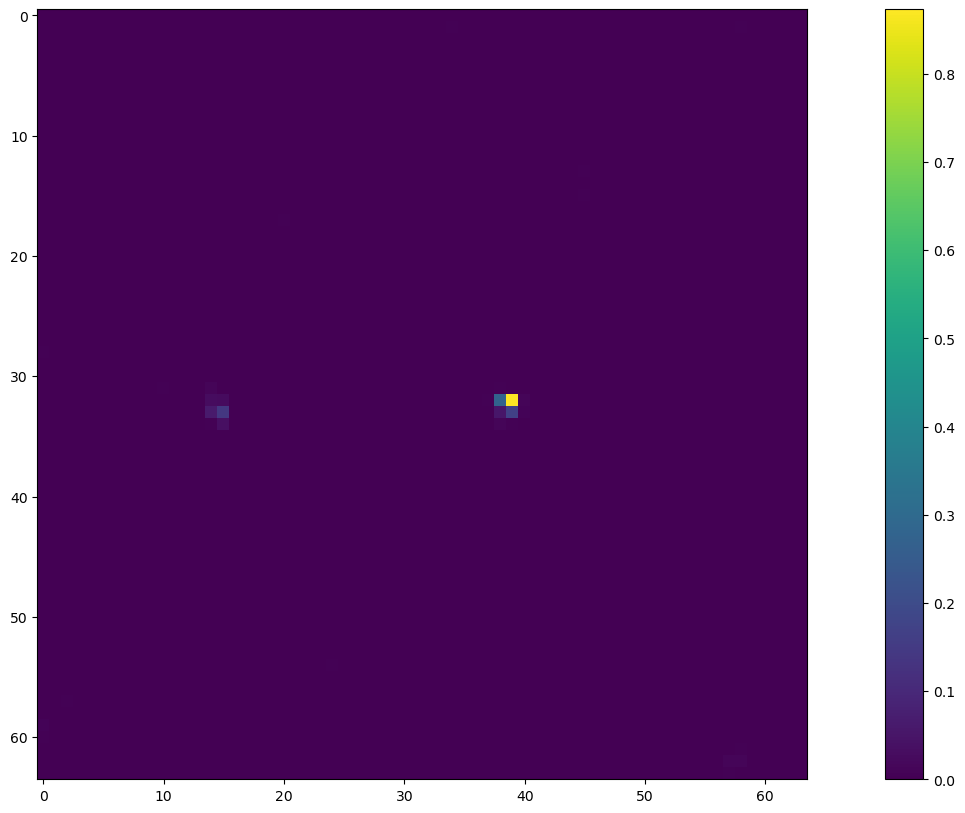

In [17]:
plt.imshow(yp_heat[0, 0])
plt.colorbar()

In [18]:
yp[0][:20]

tensor([[1.3108e+02, 1.5710e+02, 8.6428e+00, 2.2391e+01, 0.0000e+00, 8.7331e-01],
        [1.3379e+02, 6.0619e+01, 1.2863e+01, 1.0822e+01, 0.0000e+00, 1.4163e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e

In [19]:
y[:6]

tensor([[133.8933,  60.5600,  12.5333,  13.4400,   0.0000,   1.0000],
        [131.5200, 156.7800,  11.5200,  19.8800,   0.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_21376\2386193706.py:11: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  yc - hy//2 - thick : yc - hy//2 + thick,
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_21376\2386193706.py:12: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  xc - wx//2 : xc + wx//2,
C:\Users\Aleksei\AppData\Local\Temp\ip

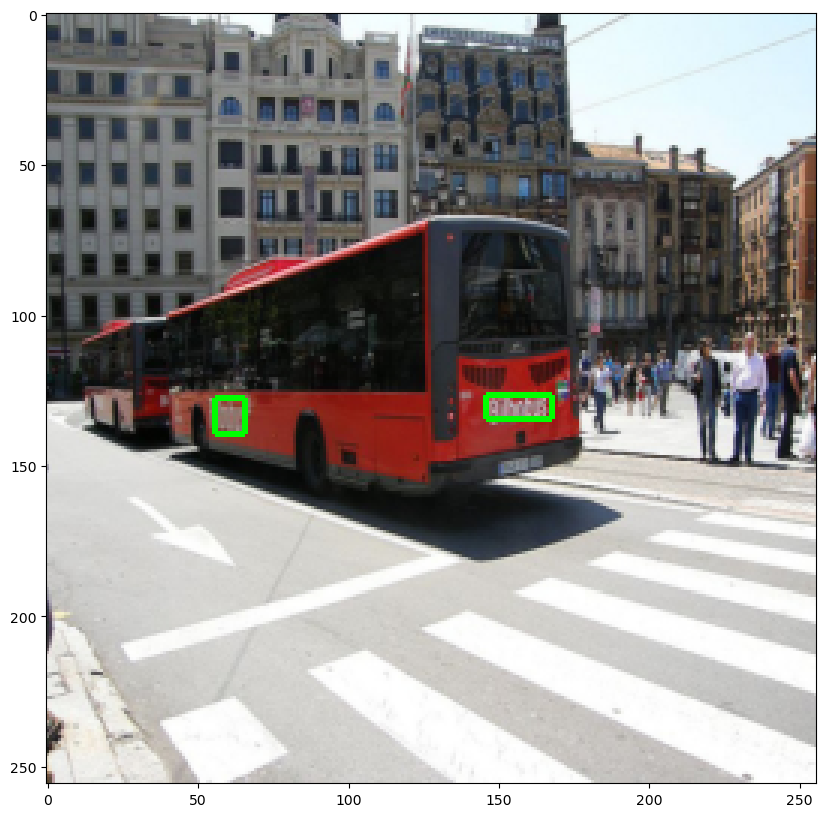

In [20]:
rnd = lambda x: torch.round(x).long()

plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
));